In [1]:
import zipfile
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

SEED = 4

# Load split data

In [ ]:
!wget 'https://github.com/jkorzeniovski/projekt_zesp/raw/main/data/skin_diseases_split.zip'

In [3]:
zip_ref = zipfile.ZipFile('skin_diseases_split.zip')
zip_ref.extractall()
zip_ref.close()

# Process Images

In [4]:
TRAIN_DIR = "/content/data/train"
VAL_DIR = "/content/data/val"
TEST_DIR = "/content/data/test"

CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
CLASSES_NUM = len(CLASS_NAMES)

INPUT_SHAPE = (192,192,3)
IMG_SIZE=INPUT_SHAPE[:2]
EPOCHS=50
BATCH_SIZE=32

In [5]:
# Use ImageDataGenerator for loading and preprocessing images
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to be between 0 and 1
    shear_range=0.2,          # Apply random shear transformations
    zoom_range=0.2,           # Apply random zoom transformations
    horizontal_flip=True,     # Flip images horizontally
    rotation_range=45,        # Rotate
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images in batches from the directories
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2340 images belonging to 19 classes.
Found 269 images belonging to 19 classes.
Found 691 images belonging to 19 classes.


# Model Training

In [6]:
base_model = InceptionV3(include_top=False,
                        weights='imagenet',
                        input_shape=INPUT_SHAPE,
                        classes=CLASSES_NUM,)

# Freeze layers
for layer in base_model.layers:
  layer.trainable = False

# Create a model on top of pretrained one.
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2054, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(CLASSES_NUM, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

early_stopping_cb = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Metric to monitor
    factor=0.3,            # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-7,           # Lower bound on the learning rate.
    verbose=1              
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping_cb, reduce_lr]
)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/50
73/73 [==============================] - 217s 3s/step - loss: 3.0685 - accuracy: 0.2621 - val_loss: 3.0366 - val_accuracy: 0.2773 - lr: 0.0010
Epoch 2/50
73/73 [==============================] - 233s 3s/step - loss: 2.2691 - accuracy: 0.3614 - val_loss: 2.4841 - val_accuracy: 0.3633 - lr: 0.0010
Epoch 3/50
73/73 [==============================] - 208s 3s/step - loss: 2.0333 - accuracy: 0.4025 - val_loss: 2.4075 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 4/50
73/73 [==============================] - 207s 3s/step - loss: 1.9229 - accuracy: 0.4146 - val_loss: 2.0952 - val_accuracy: 0.3633 - lr: 0.0010
Epoch 5/50
73/73 [==============================] - 213s 3s/step - loss: 1.8563 - accuracy: 0.4398 - val_loss: 2.0568 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/50
73/73 [==============================] - 210s 3s/step - loss: 1.8316 - accuracy: 0.4346 - val_loss: 2.0287 - val_accuracy: 0.3945 - lr: 0.0010
Epoch 7/50


# Model Evaluation

### Accuracy and Loss

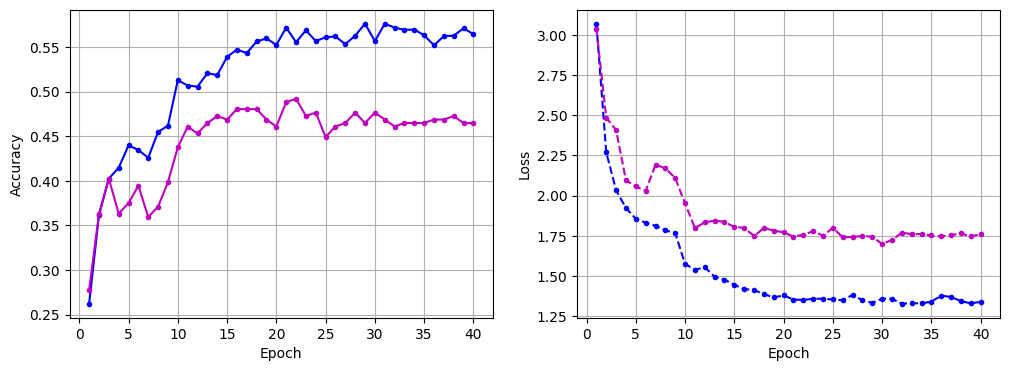

In [7]:
# Plot history
plt.figure(figsize=(12,4))

num_epochs_trained = len(history.history['accuracy'])
# Accuracy vs. epochs
plt.subplot(121, xlabel='Epoch', ylabel='Accuracy')
plt.plot(np.arange(1, num_epochs_trained+1), history.history['accuracy'], 'b.-', label='Training accuracy')
plt.plot(np.arange(1, num_epochs_trained+1), history.history['val_accuracy'], 'm.-', label='Validation accuracy')
plt.grid(True)

# Loss vs. epochs
plt.subplot(122, xlabel='Epoch', ylabel='Loss')
plt.plot(np.arange(1, num_epochs_trained+1), history.history['loss'], 'b.--', label='Training loss')
plt.plot(np.arange(1, num_epochs_trained+1), history.history['val_loss'], 'm.--', label='Validation loss')
plt.grid(True)

In [8]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

<ipython-input-8-0a2d5b839306>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples // BATCH_SIZE)


Test Accuracy: 46.58%


### Confusion Matrix

In [9]:
true_labels = []
predicted_labels = []

# Use the model to predict labels for the test set
for i in range(test_generator.samples // BATCH_SIZE):
  images, labels = next(test_generator)
  true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to integers
  predictions = model.predict(images)
  predicted_labels.extend(np.argmax(predictions, axis=1))

1/1 [==============================] - 3s 3s/step


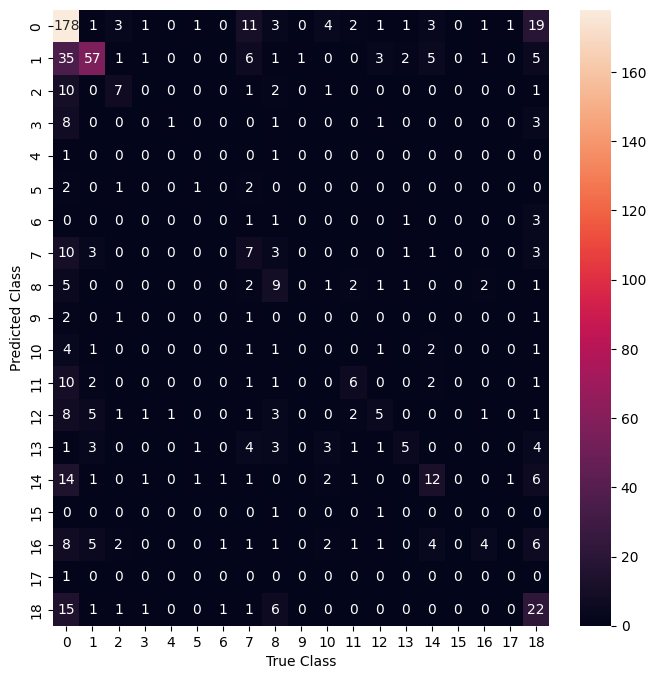

In [10]:
# Show confusion matrix based on predictions
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=plt.gca())
plt.gca().set(xlabel="True Class", ylabel="Predicted Class");

In [15]:
# Print text labels
for i in range(len(CLASS_NAMES)):
    print(f"{i} - {CLASS_NAMES[i]}")

0 - Acne and Rosacea Photos
1 - Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
2 - Atopic Dermatitis Photos
3 - Cellulitis Impetigo and other Bacterial Infections
4 - Eczema Photos
5 - Exanthems and Drug Eruptions
6 - Herpes HPV and other STDs Photos
7 - Light Diseases and Disorders of Pigmentation
8 - Lupus and other Connective Tissue diseases
9 - Melanoma Skin Cancer Nevi and Moles
10 - Poison Ivy Photos and other Contact Dermatitis
11 - Psoriasis pictures Lichen Planus and related diseases
12 - Seborrheic Keratoses and other Benign Tumors
13 - Systemic Disease
14 - Tinea Ringworm Candidiasis and other Fungal Infections
15 - Urticaria Hives
16 - Vascular Tumors
17 - Vasculitis Photos
18 - Warts Molluscum and other Viral Infections


### Grad-CAM (Gradient-weighted Class Activation Mapping)
We will visualize the regions of the input images that the model focuses on during prediction. This will show which parts of the image are important for the model's decision.

In [ ]:
base_model.summary()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2054)              4208646   
                                                                 
 batch_normalization_94 (Ba  (None, 2054)              8216      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 2054)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               1

In [13]:
def get_grad_cam(model, img_path, class_index):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=INPUT_SHAPE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.nasnet.preprocess_input(img_array)

    # Get the last convolutional layer and the output layer
    last_conv_layer = model.get_layer("inception_v3").get_layer("mixed10")  # Adjust based on the NASNetMobile architecture
    classifier_layer = model.layers[-1]

    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer_model = tf.keras.models.Model(model.get_layer("inception_v3").inputs, last_conv_layer.output)

    # Create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    x = model.get_layer("global_average_pooling2d")(x)
    x = model.get_layer("dense")(x)
    x = model.get_layer("batch_normalization_94")(x)
    x = model.get_layer("dropout")(x)
    x = model.get_layer("dense_1")(x)
    x = model.get_layer("batch_normalization_95")(x)
    x = model.get_layer("dense_2")(x)
    classifier_model = tf.keras.models.Model(classifier_input, x)

    # Compute the gradient of the top predicted class for the specified class index
    with tf.GradientTape() as tape:
        # Get the feature map of the last conv layer
        last_conv_layer_output = last_conv_layer_model(img_array)
        # Make the model output predictions for the input image
        preds = classifier_model(last_conv_layer_output)
        # Retrieve the prediction for the specified class index
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Obtain the gradient of the top class with respect to the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the top class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Average the resulting heatmap along the channel dimension to obtain the heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(cv2.cvtColor(np.uint8(img_array[0]), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

    return superimposed_img

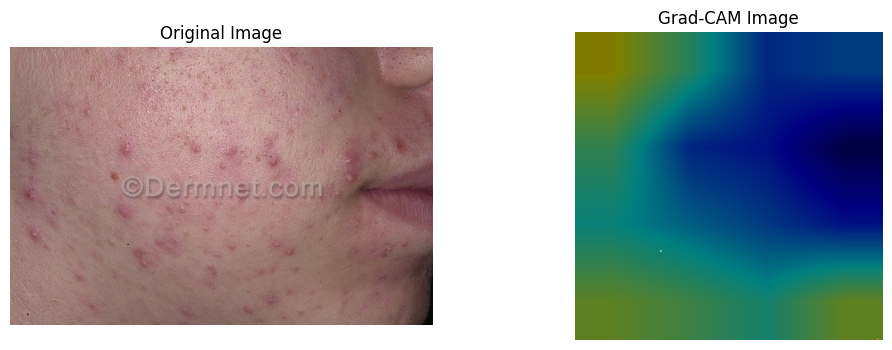

In [14]:
img_path = '/content/data/train/Acne and Rosacea Photos/07Acne081101.jpg'
class_index = 0 
grad_cam_img = get_grad_cam(model, img_path, class_index)

# Load the original image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Display the original and Grad-CAM images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(grad_cam_img)
axes[1].set_title('Grad-CAM Image')
axes[1].axis('off');

In [16]:
model.save("inceptionv3_trained_model.keras")